In [4]:
import numpy as np
import os
import PIL
import tensorflow as tf

In [5]:
import pathlib
data_dir = pathlib.Path('../Data/age/').with_suffix('')

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

8400


In [7]:
batch_size = 32
img_height = 150
img_width = 150

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split = 0.2, subset="training",seed=123,image_size=(img_height,img_width),batch_size=batch_size,label_mode='categorical'
)
steps_per_epoch = len(train_ds)//batch_size
#train_ds=train_ds.repeat()

Found 8400 files belonging to 6 classes.
Using 6720 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split = 0.2, subset="validation",seed=123,image_size=(img_height,img_width),batch_size=batch_size,label_mode='categorical'
)
validation_steps = len(val_ds)//batch_size
#val_ds = val_ds.repeat()

Found 8400 files belonging to 6 classes.
Using 1680 files for validation.


In [10]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # Persentase data untuk validation set (tidak digunakan)
    subset="validation",   # Menggunakan subset validation set (sebagai test set)
    seed=42,               # Seed untuk random splitting
    image_size=(150, 150), # Ukuran gambar yang diinginkan
    batch_size=batch_size,
    label_mode='categorical'
)

Found 8400 files belonging to 6 classes.
Using 1680 files for validation.


In [11]:
class_name = val_ds.class_names
class_name

['balita', 'dewasa', 'kanak', 'lansia', 'manula', 'remaja']

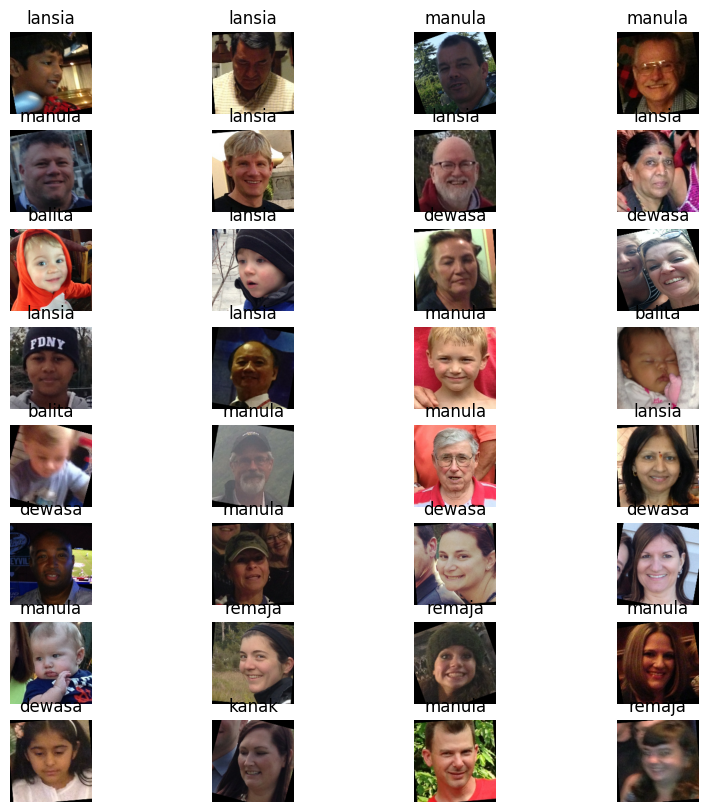

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(32):
        ax=plt.subplot(8,4,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_name[np.argmax(labels[i])])
        plt.axis('off')

In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 150, 150, 3)
(32, 6)


In [14]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [15]:
normalized_train = train_ds.map(lambda x,y: (normalization_layer(x),y))
image_batch,labels_batch = next(iter(normalized_train))
first_image = image_batch[0]
print(np.min(first_image),np.max(first_image))

0.0 0.9682423


In [16]:
normalized_val = val_ds.map(lambda x,y: (normalization_layer(x),y))
image_batch,labels_batch = next(iter(normalized_val))
first_image = image_batch[0]
print(np.min(first_image),np.max(first_image))

0.0 0.99942666


In [17]:
normalized_test = test_ds.map(lambda x,y: (normalization_layer(x),y))
image_batch,labels_batch = next(iter(normalized_test))
first_image = image_batch[0]
print(np.min(first_image),np.max(first_image))

0.0 1.0


In [18]:
#normalized_train = normalized_train.repeat()
#normalized_val = normalized_val.repeat()

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
normalized_train_ds = normalized_train.prefetch(buffer_size=AUTOTUNE)#.cache(filename='cache')
normalized_val_ds = normalized_val#.cache(filename='cache')#.prefetch(buffer_size=AUTOTUNE)

normalized_train_ds = normalized_train_ds.repeat()
#normalized_val_ds = normalized_val_ds#.repeat()

In [21]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.mobilenet import MobileNet
# grader-required-cell

# GRADED FUNCTION: create_model
def create_model():
  # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
  # USE AT LEAST 3 CONVOLUTION LAYERS

  base_model = MobileNet(weights='imagenet', include_top=False)
  base_model.trainable = False
  #for layer in base_model.layers[:100]:
  #  layer.trainable = False
#
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  predictions = tf.keras.layers.Dense(6, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)

  #model = tf.keras.models.Sequential([ 
  #    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
  #    tf.keras.layers.MaxPooling2D(2,2),
  #    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
  #    tf.keras.layers.MaxPooling2D(2,2),
  #    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
  #    tf.keras.layers.MaxPooling2D(2,2),
  #    tf.keras.layers.Flatten(),
  #    tf.keras.layers.Dropout(0.2),
  #    tf.keras.layers.Dense(512,activation='relu'),
  #    tf.keras.layers.Dense(6,activation='softmax')
  #])

  
  model.compile(optimizer=Adam(learning_rate=1e-3),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 
    
  ### END CODE HERE

  return model

model = create_model()

17225924/17225924 [==============================] - 13s 1us/step


In [22]:
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, mode='max', min_delta=0.02, baseline=0.98)
#callbacks =[early_stopping]

history = model.fit(normalized_train_ds,
                    epochs=75,
                    verbose=1,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=normalized_val,
                    #validation_steps=validation_steps,
                    #callbacks=callbacks
                    )

Epoch 1/75
6/6 [==============================] - 35s 7s/step - loss: 2.3484 - accuracy: 0.1771 - val_loss: 1.7918 - val_accuracy: 0.2750
Epoch 2/75
6/6 [==============================] - 19s 4s/step - loss: 1.7797 - accuracy: 0.2604 - val_loss: 1.6539 - val_accuracy: 0.3042
Epoch 3/75
6/6 [==============================] - 19s 4s/step - loss: 1.6545 - accuracy: 0.3177 - val_loss: 1.6026 - val_accuracy: 0.3339
Epoch 4/75
6/6 [==============================] - 18s 4s/step - loss: 1.7265 - accuracy: 0.2656 - val_loss: 1.5717 - val_accuracy: 0.3458
Epoch 5/75
6/6 [==============================] - 20s 4s/step - loss: 1.5846 - accuracy: 0.3333 - val_loss: 1.5478 - val_accuracy: 0.3476
Epoch 6/75
6/6 [==============================] - 20s 4s/step - loss: 1.5999 - accuracy: 0.3073 - val_loss: 1.5327 - val_accuracy: 0.3488
Epoch 7/75
6/6 [==============================] - 20s 4s/step - loss: 1.5752 - accuracy: 0.3073 - val_loss: 1.5286 - val_accuracy: 0.3631
Epoch 8/75
6/6 [==================

In [54]:
model.evaluate(normalized_test)

53/53 [==============================] - 13s 210ms/step - loss: 0.9440 - accuracy: 0.7036


[0.9440187215805054, 0.7035714387893677]

In [1]:
import PIL
import numpy as np
img = PIL.Image.open('E:/download/6.jpeg')

img = img.resize((150,150))

image = np.array(img)/255.0
image = image.reshape((1,150,150,3))

predict = class_name[np.argmax(model.predict(image))]
print(model.predict(image))
print(class_name)
print(f'status :{predict}')
plt.imshow(img)

AttributeError: module 'PIL' has no attribute 'Image'

In [169]:
tf.keras.Model.save(model,'../models/age_models/1/')

INFO:tensorflow:Assets written to: ../models/age_models/1/assets


INFO:tensorflow:Assets written to: ../models/age_models/1/assets
